# **Data Generator :** 

**CLave :** En un proyecto de Procesamiento de Grandes Volúmenes de Datos (PGVD) un generador de datos es parte clave y necesaria porque se necesita simular un entorno de **streaming en tiempo real** (como si los tweets llegaran en vivo).


**OBJETIVO :**
Construcción de un generador coherente con la estadística de los datos reales (twiter_training.csv y twiter_validation.csv).

- Crear un generador de tweets sintéticos (simulados) que produzca datos en tiempo real (cada segundo o en ráfagas) con estructura parecida a los tweets reales, y que pueda enviar a:
    - un archivo CSV/JSON (para pruebas batch),
    - o directamente a Kafka (para streaming en Spark).

- Después, sobre esos datos se debe realizar:
    - estadísticas descriptivas,
    - limpieza,
    - y flujo de procesamiento (Spark o Hadoop).

#### ETAPA 1 — Entender los datasets originales

Es necesario analizar estadísticamente los CSV reales para identificar:

| Tipo de estadística                    | Qué buscamos                          | Ejemplo                                |
|---------------------------------------|---------------------------------------|----------------------------------------|
| Distribución de sentimientos          | % de positivos, negativos, neutros    | 60% pos, 30% neg, 10% neutro           |
| Longitud de los textos                | Promedio, desviación estándar         | media=80 caracteres                    |
| Frecuencia de hashtags o entidades    | Top 10 hashtags más usados            | #COVID19, #AI, #Sports                 |
| Idiomas / regiones                    | Conteo por país o idioma              | en=70%, es=30%                         |
| Palabras más frecuentes               | nubes de palabras y tokens clave      | "love", "hate", "great"               |

→ Estas estadísticas servirán como parámetros para el generador.  
Así, los datos sintéticos mantendrán el **mismo comportamiento** que los reales.

#### ETAPA 2 — Calcular las estadísticas base

Leer los CSV y analizar sus distribuciones.

In [112]:
import pandas as pd
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [113]:
train = pd.read_csv("data/twitter_training.csv")
valid = pd.read_csv("data/twitter_validation.csv")

train.columns = train.columns.str.strip()
valid.columns = valid.columns.str.strip()

train.head()

,Tweet ID,Entity,Sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [114]:
valid.head()

,Tweet ID,Entity,Sentiment,Tweet content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [115]:
df = pd.concat([train, valid])

df.head()

,Tweet ID,Entity,Sentiment,Tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75682 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       75682 non-null  int64 
 1   Entity         75682 non-null  object
 2   Sentiment      75682 non-null  object
 3   Tweet content  74996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.9+ MB


In [117]:
# Duplicados considerando TODAS las columnas
total_dups = df.duplicated().sum()
print(f"Total de filas duplicadas (todas las columnas): {total_dups}")

# Duplicados considerando solo el ID
id_dups = df.duplicated(subset=["Tweet ID"]).sum()
print(f"Duplicados basados en Tweet ID: {id_dups}")

# Duplicados considerando solo el contenido
text_dups = df.duplicated(subset=["Tweet content"]).sum()
print(f"Duplicados basados en el texto: {text_dups}")


Total de filas duplicadas (todas las columnas): 3217
Duplicados basados en Tweet ID: 63235
Duplicados basados en el texto: 5707


**Presencia de duplicidad semántica.**

En el dataset, varios tweets tienen el mismo Tweet ID y casi el mismo texto, con pequeñas diferencias de redacción o puntuación.

Eso ocurre porque probablemente el dataset original fue creado mediante traducciones automáticas o variantes del mismo post, por lo tanto hay duplicados semánticos (no idénticos carácter por carácter).

In [118]:
# Elimina filas con el mismo Tweet ID (mantiene solo la primera aparición)
df = df.drop_duplicates(subset=["Tweet ID"], keep="first").reset_index(drop=True)

print("Total de tweets después de eliminar duplicados:", len(df))
print("IDs únicos:", df["Tweet ID"].nunique())


Total de tweets después de eliminar duplicados: 12447
IDs únicos: 12447


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12447 entries, 0 to 12446
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       12447 non-null  int64 
 1   Entity         12447 non-null  object
 2   Sentiment      12447 non-null  object
 3   Tweet content  12447 non-null  object
dtypes: int64(1), object(3)
memory usage: 389.1+ KB


In [120]:
dups = df["Tweet ID"].duplicated().sum()
print("Tweet IDs duplicados restantes:", dups)

Tweet IDs duplicados restantes: 0


In [121]:
#Distribución porcentual de sentimientos
print(df['Sentiment'].value_counts(normalize=True))

Sentiment
Negative      0.301840
Positive      0.278943
Neutral       0.245280
Irrelevant    0.173937
Name: proportion, dtype: float64


In [122]:
#Longitud promedio de los textos
df['text_length'] = df['Tweet content'].astype(str).apply(len)
print("\nLongitud promedio del texto:")
print(df['text_length'].describe())



Longitud promedio del texto:
count    12447.000000
mean       107.634209
std         76.470142
min          1.000000
25%         48.000000
50%         91.000000
75%        151.000000
max        352.000000
Name: text_length, dtype: float64


In [123]:
#Top palabras
def tokenize(text):
    text = re.sub(r"http\S+|@\S+|#\S+", "", str(text).lower())
    words = re.findall(r'\b[a-záéíóúñü]+', text)
    return words

all_words = [w for text in df['Tweet content'] for w in tokenize(text)]
counter = Counter(all_words)
print("\nTop 20 palabras más frecuentes:")
print(counter.most_common(20))


Top 20 palabras más frecuentes:
[('the', 7076), ('i', 6230), ('to', 4882), ('and', 4298), ('a', 4072), ('of', 3270), ('is', 3092), ('it', 2915), ('this', 2714), ('for', 2690), ('in', 2591), ('you', 2155), ('on', 2062), ('my', 2040), ('s', 1925), ('com', 1913), ('t', 1647), ('that', 1612), ('with', 1451), ('game', 1416)]


In [130]:
import re
from collections import Counter

# Extraer hashtags del texto
def extract_hashtags(text):
    return re.findall(r"#\w+", str(text))

hashtags = [tag.lower() for txt in df["Tweet content"].dropna() for tag in extract_hashtags(txt)]
tag_counts = Counter(hashtags)
print(tag_counts.most_common(5))


[]


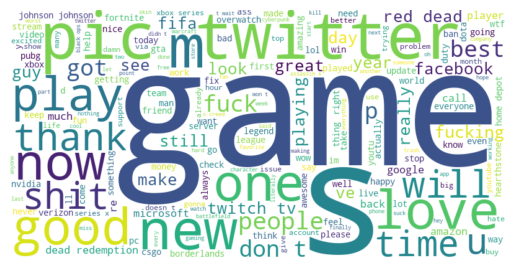

In [125]:
#Nube de palabras
text_corpus = " ".join(all_words)
wc = WordCloud(width=800, height=400, background_color="white").generate(text_corpus)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [126]:
#qué palabras aparecen más en cada clase (Sentiment)
from collections import Counter

def top_words_by_sentiment(sentiment_label, n=20):
    subset = df[df['Sentiment'] == sentiment_label]['Tweet content'].dropna()
    words = [w for text in subset for w in tokenize(text)]
    counter = Counter(words)
    return counter.most_common(n)

print("Top palabras - Positive:")
print(top_words_by_sentiment("Positive", 60))
print("\nTop palabras - Negative:")
print(top_words_by_sentiment("Negative", 60))
print("\nTop palabras - Neutral:")
print(top_words_by_sentiment("Neutral", 60))


Top palabras - Positive:
[('i', 1998), ('the', 1906), ('to', 1294), ('and', 1128), ('a', 1008), ('of', 867), ('it', 845), ('this', 809), ('is', 791), ('for', 769), ('in', 642), ('my', 571), ('s', 533), ('on', 479), ('so', 470), ('you', 448), ('com', 408), ('game', 397), ('that', 395), ('with', 369), ('be', 367), ('t', 343), ('m', 323), ('love', 317), ('me', 311), ('twitter', 300), ('pic', 294), ('was', 292), ('all', 288), ('but', 288), ('good', 280), ('just', 257), ('have', 250), ('can', 247), ('like', 236), ('are', 225), ('out', 205), ('new', 202), ('best', 202), ('really', 199), ('one', 188), ('at', 187), ('we', 184), ('playing', 176), ('now', 176), ('play', 175), ('as', 174), ('fun', 167), ('time', 162), ('from', 160), ('get', 160), ('some', 158), ('more', 156), ('great', 154), ('wait', 150), ('games', 145), ('what', 142), ('will', 139), ('ve', 136), ('thank', 135)]

Top palabras - Negative:
[('the', 2242), ('i', 2092), ('to', 1530), ('and', 1390), ('a', 1249), ('is', 1191), ('it', 

In [ ]:
# Stopwords básicas en inglés (puedes ampliarlas)
stopwords = {
    'the','to','and','a','i','it','of','in','is','for','on','this','that',
    'my','you','t','s','com','me','at','we','they','he','she','an','as','be',
    'are','was','have','has','had','will','just','do','from','by','or','if','but','so','not','now'
}

def top_words_by_sentiment(df, sentiment, n=30):
    subset = df[df['Sentiment'] == sentiment]['Tweet content'].dropna()
    counter = Counter()
    for text in subset:
        counter.update(tokenize(text))
    filtered = [(w, c) for w, c in counter.most_common(200) if w not in stopwords and len(w) > 2]
    return filtered[:n]

for s in df['Sentiment'].unique():
    print(f"\n🔹Top palabras - {s}:")
    print(top_words_by_sentiment(df, s, n=50))



🔹Top palabras - Positive:
[('game', 397), ('with', 369), ('love', 317), ('twitter', 300), ('pic', 294), ('all', 288), ('good', 280), ('can', 247), ('like', 236), ('out', 205), ('new', 202), ('best', 202), ('really', 199), ('one', 188), ('playing', 176), ('play', 175), ('fun', 167), ('time', 162), ('get', 160), ('some', 158), ('more', 156), ('great', 154), ('wait', 150), ('games', 145), ('what', 142), ('thank', 135), ('been', 129), ('dead', 129), ('red', 129), ('creed', 129), ('amazing', 126), ('about', 125), ('how', 125), ('redemption', 120), ('borderlands', 119), ('got', 118), ('see', 118), ('back', 116), ('excited', 116), ('much', 115), ('your', 114), ('still', 109), ('awesome', 106), ('nice', 105), ('xbox', 102), ('when', 102), ('twitch', 100), ('thanks', 98), ('today', 96), ('happy', 95)]

🔹Top palabras - Neutral:
[('with', 362), ('johnson', 350), ('out', 234), ('amazon', 221), ('game', 219), ('twitter', 212), ('all', 205), ('pic', 189), ('twitch', 169), ('your', 161), ('can', 154